In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, DenseNet121, ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

2025-12-15 13:21:36.113610: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765804896.502219      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765804896.637617      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
print(tf.__version__)
print(keras.__version__)

2.18.0
3.8.0


In [3]:
IMG_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 4
LEARNING_RATE = 1e-4
DROPOUT_RATE = 0.3
EPOCHS = 10
PATIENCE = 5
BATCH_SIZE = 32
SEED = 42

In [4]:
# set random seed for reproducibility
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
keras.utils.set_random_seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1' 
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# **Load Dataset**
Since the dataset only provided Training and Testing set, we're going to split the Test Set into 50% Test and 50% Validation

In [5]:
# generate data paths with labels
train_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
# print(folds)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)
train_df

,filepaths,labels
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
5707,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5708,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5709,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
5710,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma


In [6]:
# Generate data paths with labels
test_data_dir = '/kaggle/input/brain-tumor-mri-dataset/Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
temp_df = pd.concat([Fseries, Lseries], axis= 1)

In [7]:
valid_df, test_df = train_test_split(temp_df, train_size= 0.5, shuffle= True, stratify=temp_df['labels'], random_state=SEED)

In [8]:
tr_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

ts_gen = ImageDataGenerator(rescale=1./255)

train_ds = tr_gen.flow_from_dataframe(
    train_df,
    x_col= 'filepaths',
    y_col= 'labels', 
    target_size= IMG_SIZE,
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle= True,
    batch_size= BATCH_SIZE)

val_ds = ts_gen.flow_from_dataframe(
    valid_df,
    x_col= 'filepaths',
    y_col= 'labels', 
    target_size= IMG_SIZE,
    class_mode= 'categorical',
    color_mode= 'rgb',
    shuffle= False,
    batch_size= BATCH_SIZE)

test_ds = ts_gen.flow_from_dataframe(
    test_df,
    x_col= 'filepaths',
    y_col= 'labels',
    target_size= IMG_SIZE,
    class_mode= 'categorical',
    color_mode= 'rgb', 
    shuffle= False,
    batch_size= BATCH_SIZE)

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


# Preprocessing Data

# Create Model

In [9]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)
print("Number of layers in the base model: ", len(base_model.layers))

I0000 00:00:1765804930.330791      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765804930.331405      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Number of layers in the base model:  427


In [10]:
def create_model(dropout_rate, learning_rate):

    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

    total_layers = len(base_model.layers)
    # how many layers to unfreeze
    n_unfreeze = int(total_layers * (30 / 100.0)) # unfreeze 30% of the base's layers
    
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-n_unfreeze:]:
        layer.trainable = True
    
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = create_model(
    dropout_rate = DROPOUT_RATE,
    learning_rate = LEARNING_RATE
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,041,604 (26.86 MB)

 Trainable params: 2,893,508 (11.04 MB)

 Non-trainable params: 4,148,096 (15.82 MB)

# Training

In [11]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data = val_ds,
    callbacks=EarlyStopping(monitor='val_loss', patience=PATIENCE, verbose=1, restore_best_weights=True)
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1765804966.579868     107 cuda_dnn.cc:529] Loaded cuDNN version 90300


179/179 ━━━━━━━━━━━━━━━━━━━━ 173s 793ms/step - accuracy: 0.7573 - loss: 0.6214 - val_accuracy: 0.9252 - val_loss: 0.2168
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 104s 579ms/step - accuracy: 0.9291 - loss: 0.1933 - val_accuracy: 0.9313 - val_loss: 0.1600
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 102s 572ms/step - accuracy: 0.9513 - loss: 0.1300 - val_accuracy: 0.9695 - val_loss: 0.0898
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 102s 571ms/step - accuracy: 0.9657 - loss: 0.1018 - val_accuracy: 0.9679 - val_loss: 0.1086
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 102s 570ms/step - accuracy: 0.9738 - loss: 0.0792 - val_accuracy: 0.9756 - val_loss: 0.0539
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 102s 571ms/step - accuracy: 0.9768 - loss: 0.0654 - val_accuracy: 0.9710 - val_loss: 0.0585
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 102s 572ms/step - accuracy: 0.9854 - loss: 0.0459 - val_accuracy: 0.9863 - val_loss: 0.0432
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 103s 576ms/step - accuracy: 0.9809 - loss: 0.05

# Evaluation

In [12]:
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [19]:
# Evaluation Functions (plot history & evaluation metrics)
def evaluate_model(model, test_ds, num_classes, class_names=class_names):
    y_pred_probs = model.predict(test_ds, verbose=1)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = test_ds.classes
    
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

    report = classification_report(y_true_classes, y_pred_classes, target_names=class_names if class_names else [f'Class {i}' for i in range(num_classes)])
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    results = {
        "overall_accuracy": accuracy,
        "weighted_precision": precision,
        "weighted_recall": recall,
        "weighted_f1_score": f1,
        "classification_report": report,
        "confusion_matrix": conf_matrix
    }

    print("\n=== MODEL EVALUATION ===")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")
    print(f"Macro F1-Score: {f1_score(y_true_classes, y_pred_classes, average='macro'):.4f}")
    print("\nClassification Report:\n", report)
    print('\n')
    # plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.show()

    return results
    
def plot_training_history(history, title_prefix="Model Performance"):
    hist_df = pd.DataFrame(history.history)
    hist_df['epoch'] = hist_df.index + 1
    epochs = len(hist_df)

    plt.figure(figsize=(12, 5))
    plt.plot(hist_df['epoch'], hist_df['accuracy'], label='Training Accuracy', marker='o', linestyle='-', color='blue')
    plt.plot(hist_df['epoch'], hist_df['val_accuracy'], label='Validation Accuracy', marker='s', linestyle='--', color='darkorange')
    
    plt.title(f'{title_prefix} - Training vs Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(np.arange(1, epochs + 1, max(1, epochs // 10)))
    plt.grid(True, linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.plot(hist_df['epoch'], hist_df['loss'], label='Training Loss', marker='o', linestyle='-', color='blue')
    plt.plot(hist_df['epoch'], hist_df['val_loss'], label='Validation Loss', marker='s', linestyle='--', color='darkorange')
    
    min_val_loss = hist_df['val_loss'].min()
    best_epoch = hist_df['val_loss'].idxmin() + 1
    
    plt.axvline(x=best_epoch, color='red', linestyle=':', linewidth=2, label=f'Best Epoch ({best_epoch})')

    plt.title(f'{title_prefix} - Training vs Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(np.arange(1, epochs + 1, max(1, epochs // 10)))
    plt.grid(True, linestyle='--')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\n--- Best Performance ---")
    print(f"Best Epoch: {best_epoch}")
    print(f"Min Validation Loss: {min_val_loss:.4f}")
    print(f"Best Validation Accuracy at Best Epoch: {hist_df.loc[hist_df.index[best_epoch-1], 'val_accuracy']:.4f}")

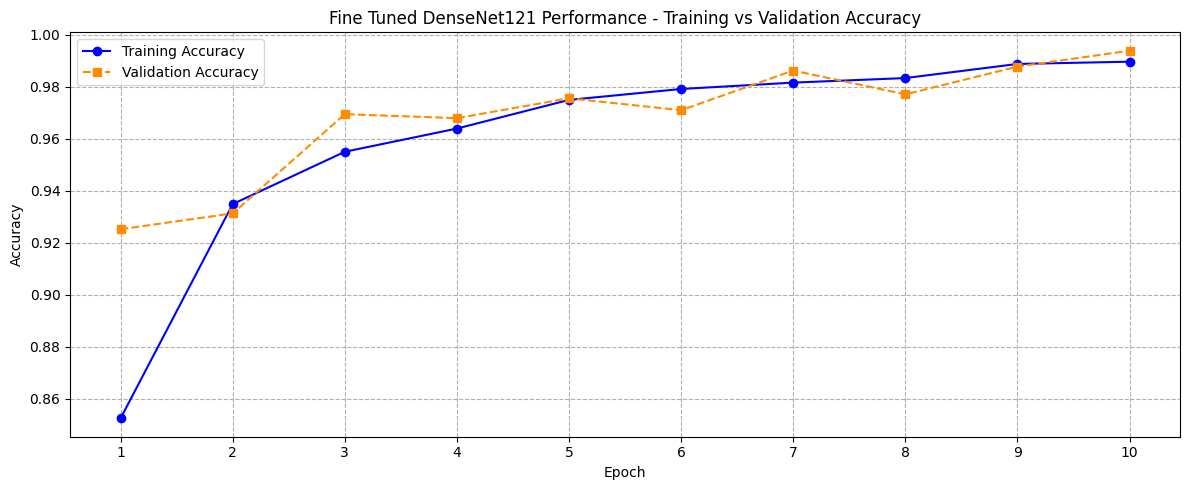

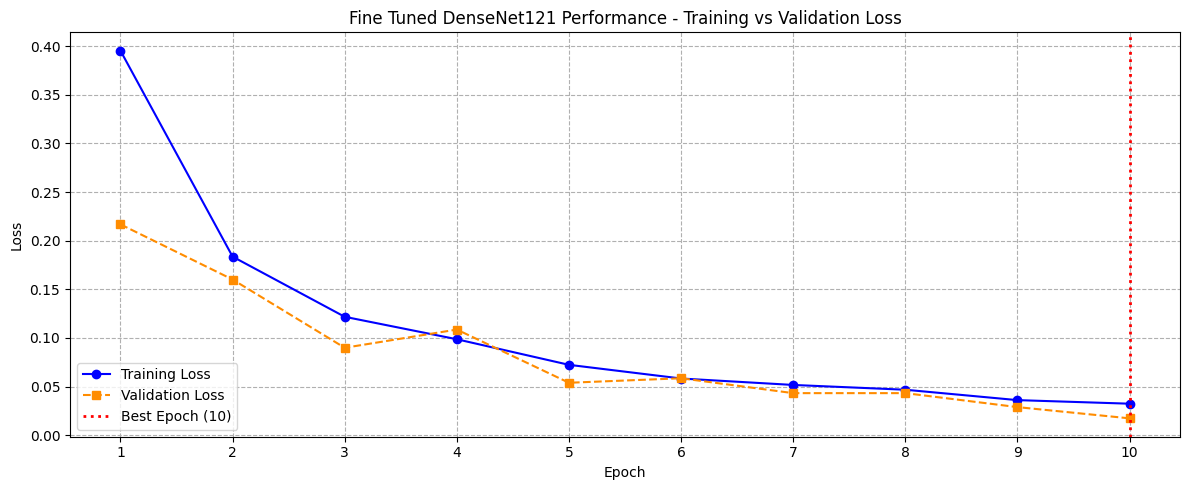


--- Best Performance ---
Best Epoch: 10
Min Validation Loss: 0.0173
Best Validation Accuracy at Best Epoch: 0.9939


In [14]:
plot_training_history(history, "Fine Tuned DenseNet121 Performance")

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step

=== MODEL EVALUATION ===
Overall Accuracy: 0.9924
Weighted Precision: 0.9924
Weighted Recall: 0.9924
Weighted F1-Score: 0.9924
Macro F1-Score: 0.9920

Classification Report:
               precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       150
  meningioma       0.99      0.98      0.98       153
     notumor       1.00      1.00      1.00       203
   pituitary       0.99      1.00      0.99       150

    accuracy                           0.99       656
   macro avg       0.99      0.99      0.99       656
weighted avg       0.99      0.99      0.99       656





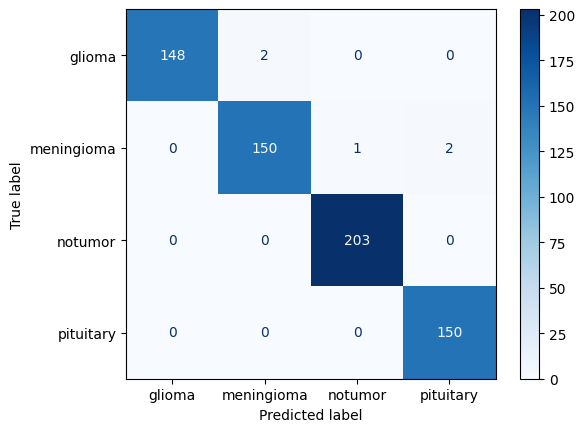

In [20]:
result_densenet121 = evaluate_model(model, test_ds, NUM_CLASSES, class_names=class_names)

# Save Model

In [16]:
model.save('densenet121_model.keras')
print('model is saved!')

model is saved!
